In [26]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from random import randint

(1600, 1600, 4)


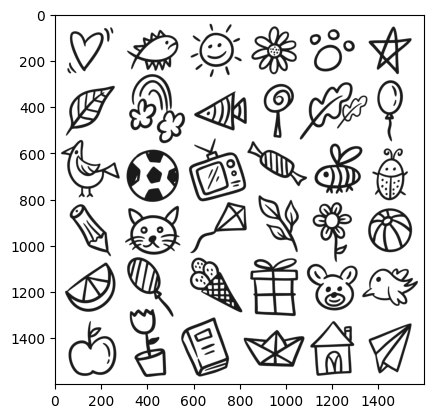

In [27]:
def read_source(filename):
    """
    returns source image as RGBA
    """
    img = cv.imread(filename, cv.IMREAD_UNCHANGED)
    img = cv.cvtColor(img, cv.COLOR_RGB2RGBA)
    return img

source = read_source('0004.png')
height, width, channels = source.shape # 4 channels
print(source.shape)
plt.imshow(source)

(1600, 1600)


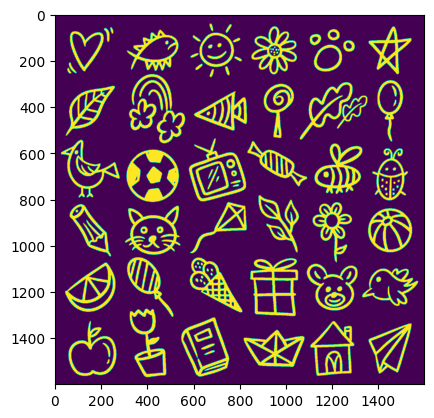

In [28]:
def prepare_for_contouring(img, threshold_min=127, threshold_max=255):
    """
    removes alpha, thresholds, converts to grayscale white on black
    """
    img2 = img[:,:,:3]
    trans_mask = img[:,:,3] == 0
    img2[trans_mask] = [255, 255, 255] # fill transparent with white
    ret, img2 = cv.threshold(img[:,:,:3], threshold_min, threshold_max, cv.THRESH_BINARY_INV)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    return img2

prepared_img = prepare_for_contouring(source)
print(prepared_img.shape)
plt.imshow(prepared_img)

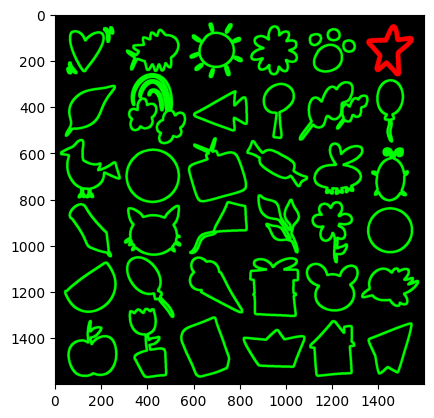

In [29]:
contours, hierarchy = cv.findContours(prepared_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# visualize contours

contour_index = randint(0, len(contours) - 1) # arbitrary contour
visualize_img = np.zeros((height, width, 3), np.uint8)
cv.drawContours(visualize_img, contours, -1, (0, 255, 0), 10) # all contours in green
cv.drawContours(visualize_img, contours, contour_index, (255, 0, 0), 20) # selected contour in red
plt.imshow(visualize_img)

(206, 186, 4)


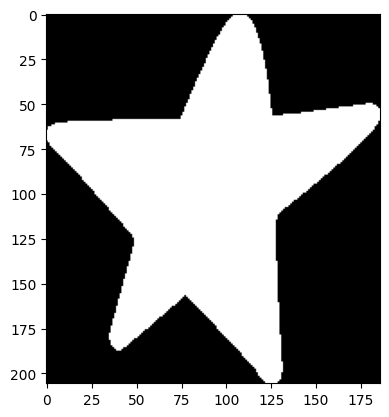

In [30]:
def get_mask(source, contours, contour_index):
    """
    isolates source rectangle with contour and draws the mask
    (transparent mask on black background)
    """
    height, width, channels = source.shape
    mask = np.zeros((height, width, 3), np.uint8)
    mask = cv.cvtColor(mask, cv.COLOR_RGB2RGBA)
    mask = cv.drawContours(mask, contours, contour_index, (0, 0, 0, 0), -1)
    x, y, w, h = cv.boundingRect(contours[contour_index])
    return mask[y:y+h, x:x+w]

mask = get_mask(source, contours, contour_index)
print(mask.shape)
plt.imshow(mask)

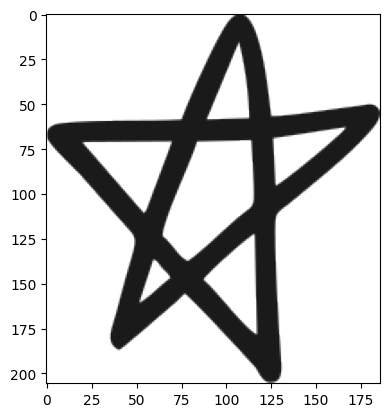

In [31]:
def apply_mask(source, contours, contour_index, mask):
    """
    isolates source rectangle with contour and applies the mask
    (result is a destination image on transparent background)
    """
    x, y, w, h = cv.boundingRect(contours[contour_index])
    cropped = source[y:y+h, x:x+w]
    result = np.bitwise_and(cropped, np.bitwise_not(mask))
    return result

mask_applied = apply_mask(source, contours, contour_index, mask)
plt.imshow(mask_applied)

(208, 188, 4)


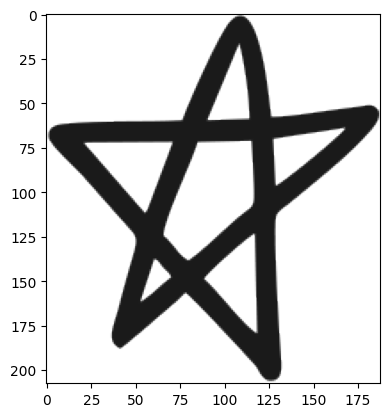

In [32]:
def add_padding(img, grid_size=4):
    height, width, channels = img.shape
    rh = int(np.ceil(height / grid_size) * grid_size)
    rw = int(np.ceil(width / grid_size) * grid_size)
    offset_h = (rh - height) // 2
    offset_w = (rw - width) // 2
    result = np.zeros((rh, rw, channels), np.uint8)
    result[offset_h:offset_h+height, offset_w:offset_w+width] = img
    return result

result = add_padding(mask_applied)
print(result.shape)
plt.imshow(result)

In [33]:
for contour_index in range(len(contours)):
    mask = get_mask(source, contours, contour_index)
    dest = add_padding(apply_mask(source, contours, contour_index, mask))
    cv.imwrite(f'dest/{contour_index}.png', dest)